In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.stattools import coint
import matplotlib.cm as cm

In [2]:
data = pd.read_csv("SP500_constitutes_modified.csv")

In [3]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

In [4]:
prices = data.drop("Date", axis=1)

In [5]:
returns = prices.pct_change().dropna()

In [6]:
N_PRIN_COMPONENTS = 50
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(returns)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0.5, 1.0, 'scree plot for PCA')

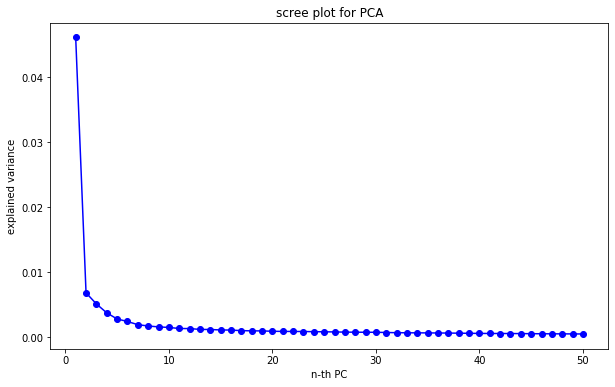

In [7]:
# A "scree" plot.
plt.figure(figsize=(10,6))
plt.plot(range(1,51),pca.explained_variance_,'b-o')
plt.ylabel("explained variance")
plt.xlabel("n-th PC")
plt.title("scree plot for PCA")

In [8]:
X = pca.components_.T
X = preprocessing.StandardScaler().fit_transform(X)

In [11]:
clf = DBSCAN(eps=3, min_samples=3)
#clf = KMeans()
print(clf)

clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("\nClusters discovered: %d" % n_clusters_)

clustered = clf.labels_

DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=3, n_jobs=None, p=None)

Clusters discovered: 10


In [12]:
clustered_series = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print("Clusters formed: %d" % len(ticker_count_reduced))
print("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 10
Pairs to evaluate: 2242


In [13]:
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)

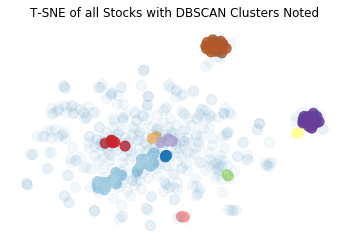

In [22]:
plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')

plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=labels[labels!=-1],
    cmap=cm.Paired
)

plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted')
plt.savefig("tsne.png")

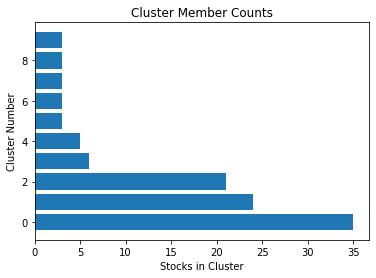

In [15]:
plt.barh(
    range(len(clustered_series.value_counts())),
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number');

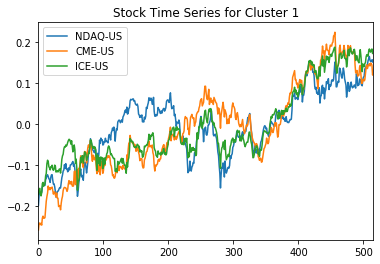

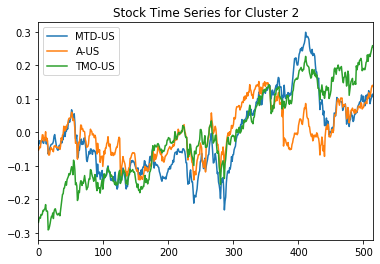

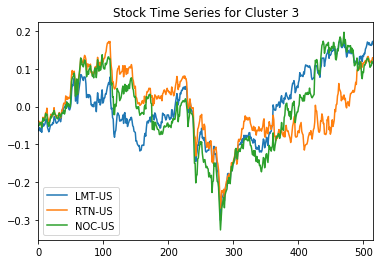

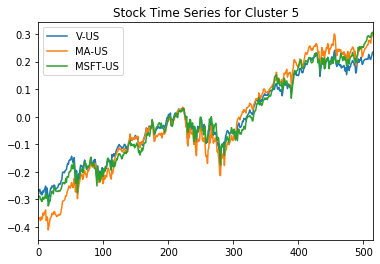

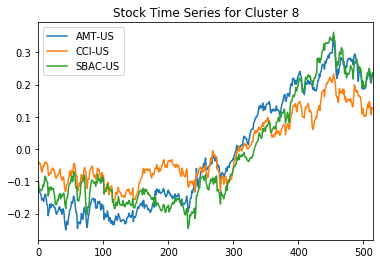

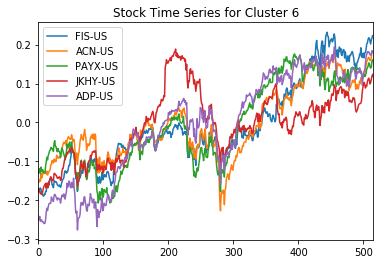

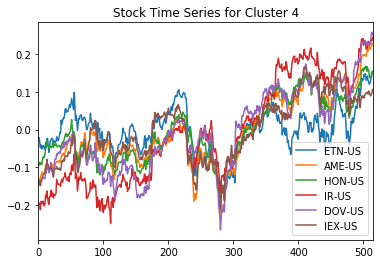

In [16]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

# plot a handful of the smallest clusters
for clust in cluster_vis_list:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(prices[tickers].mean())
    data = np.log(prices[tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)

In [17]:
def find_cointegrated_pairs(data, significance=0.5):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [18]:
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        prices[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [19]:
print("We found %d pairs." % len(pairs))

We found 2 pairs.


In [20]:
pairs

[('NDAQ-US', 'ICE-US'), ('CME-US', 'ICE-US')]

In [168]:
data[['NDAQ-US', 'ICE-US']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 2 columns):
NDAQ-US    516 non-null float64
ICE-US     516 non-null float64
dtypes: float64(2)
memory usage: 8.1 KB
